In [1]:
import torch
import numpy as np
import root_pandas
import pandas as pd

Welcome to JupyROOT 6.12/07


In [2]:
# Copy TTree HZZ4LeptonsAnalysisReduced into a pandas DataFrame.
filename = {
    'VV': root_pandas.read_root('data/ntuple_4mu_VV.root', key='HZZ4LeptonsAnalysisReduced'),
    'bkg': root_pandas.read_root('data/ntuple_4mu_bkg.root', key='HZZ4LeptonsAnalysisReduced')
}

# Drop all variables except for those we want to use when training.
VARS = ['f_mass4l','f_massjj']
df = {
    'VV': filename['VV'][VARS],
    'bkg': filename['bkg'][VARS],
}

In [3]:
# Make sure the inputs are well behaved.
df['VV']= df['VV'][(df['VV'][VARS[0]] > -999) & (df['VV'][VARS[1]] > -999)]
df['bkg']= df['bkg'][(df['bkg'][VARS[0]] > -999) & (df['bkg'][VARS[1]] > -999)] 

In [4]:
# add isSignal variable
df['VV']['isSignal'] = np.ones(len(df['VV'])) 
df['bkg']['isSignal'] = np.zeros(len(df['bkg'])) 

In [5]:
# Combine signal and background into one DataFrame then split into input variables and labels.
NDIM = len(VARS)
df_all = pd.concat([df['VV'],df['bkg']])
dataset = df_all.values
X = dataset[:,0:NDIM]
Y = dataset[:,NDIM]

# Split into training and testing data.
from sklearn.model_selection import train_test_split
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2, random_state=7)
print(X_train_val)
print(X)

# preprocessing: standard scalar (reshape inputs to mean=0, variance=1)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train_val)
X_train_val = scaler.transform(X_train_val)
X_test = scaler.transform(X_test)

# Split again, this time into training and validation data.
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.2, random_state=7)

[[ 123.59499359 1071.21447754]
 [ 124.97003174 1074.65454102]
 [ 124.32479095  643.70874023]
 ...
 [  87.93131256  538.8001709 ]
 [ 120.99951935  772.50964355]
 [  90.16904449  194.7850647 ]]
[[ 125.07710266 1300.42687988]
 [ 124.2381134   437.22186279]
 [ 124.48066711 1021.74407959]
 ...
 [  89.28808594   53.66157913]
 [ 146.75657654   71.16202545]
 [ 218.86941528   98.91469574]]


In [6]:
# Build our model. 
import torch
model = torch.nn.Sequential(
    torch.nn.Linear(2, 20),
    torch.nn.Sigmoid(),
    torch.nn.Linear(20, 20),
    torch.nn.Sigmoid(),
    torch.nn.Linear(20, 1),
    torch.nn.Sigmoid()
)

# Use Binary Cross Entropy as our loss function.
loss_fn = torch.nn.BCELoss()

# Optimize the model parameters using the Adam optimizer.
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [7]:
import math
def getBatches(N, tot):
    """Function to find nearest acceptable batch size"""
    print N, tot
    if tot % N == 0:
        return N
    closest = 1
    for i in xrange(1, N):
        if tot % i == 0 and abs(N - i) < abs(N-closest):
            closest = i
    return closest
    
# Create batches from total data. We have to make sure the batch size is an appropriate divisor of the total 
# number of training events
N = getBatches(1024, len(X_train))
unbatched_x = torch.from_numpy(X_train).float()
x = unbatched_x.view(-1, N, len(VARS))
unbatched_y = torch.from_numpy(Y_train).float()
y_b = unbatched_y.view(-1, N, 1)

1024 13272


In [8]:
# Get validation data ready
val_data = torch.from_numpy(X_val).float()
val_label = torch.from_numpy(Y_val).float()

In [9]:
losses, val_losses = [], []
min_loss, stale_epochs = 100., 0

# 500 epochs. 
for t in xrange(500):
    batch_loss, val_batch_loss = [], []
    for b in xrange(len(x)):
        
        # Forward pass: make a prediction for each x event in batch b.
        y_pred = model(x[b])

        # Get the labels.
        label = y_b[b]
        y = label.view_as(y_pred)  # reshape label data to the shape of y_pred

        # Compute and print loss.
        loss = loss_fn(y_pred, y)
        batch_loss.append(loss.item())

        # Let's look at the validation set.
        
        # Torch keeps track of each operation performed on a Tensor, so that it can take the gradient later.
        # We don't need to store this information when looking at validation data, so turn it off with
        # torch.no_grad().
        with torch.no_grad():
            
            # Forward pass on validation set.
            output = model(val_data)

            # Get labels and compute loss again
            val_y = val_label.view_as(output)
            val_loss = loss_fn(output, val_y)
            val_batch_loss.append(val_loss.item())

            # Monitor the loss function to prevent overtraining.
            if stale_epochs > 20:
                break

            if val_loss.item() - min_loss < 0:
                min_loss = val_loss.item()
                stale_epochs = 0
            else:
                stale_epochs += 1

        print(t, b, loss.item(), val_loss.item())

        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the variables it will update (which are the learnable
        # weights of the model). This is because by default, gradients are
        # accumulated in buffers( i.e, not overwritten) whenever .backward()
        # is called. Checkout docs of torch.autograd.backward for more details.
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model
        # parameters
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its
        # parameters
        optimizer.step()
        
    losses.append(min(batch_loss))
    val_losses.append(min(val_batch_loss))

(0, 0, 0.6605303287506104, 0.661753237247467)
(0, 1, 0.6595340371131897, 0.6583295464515686)
(0, 2, 0.6504634022712708, 0.6549726128578186)
(0, 3, 0.6557813286781311, 0.6516584753990173)
(0, 4, 0.6451826095581055, 0.6484383940696716)
(0, 5, 0.6455895900726318, 0.6452593207359314)
(0, 6, 0.637454092502594, 0.6421424746513367)
(0, 7, 0.6399141550064087, 0.6390732526779175)
(0, 8, 0.6334809064865112, 0.6360737681388855)
(0, 9, 0.6323860287666321, 0.6331309676170349)
(0, 10, 0.6322687268257141, 0.6302533745765686)
(0, 11, 0.6276381611824036, 0.6274492144584656)
(0, 12, 0.6284269690513611, 0.6247081160545349)
(0, 13, 0.61933434009552, 0.6220443248748779)
(1, 0, 0.6160424947738647, 0.6194333434104919)
(1, 1, 0.6200253367424011, 0.616877555847168)
(1, 2, 0.6039753556251526, 0.6143941283226013)
(1, 3, 0.6213995814323425, 0.6119483113288879)
(1, 4, 0.6026436686515808, 0.6095945835113525)
(1, 5, 0.6079285144805908, 0.6072854399681091)
(1, 6, 0.5962136387825012, 0.6050411462783813)
(1, 7, 0.60441

(12, 10, 0.5283499360084534, 0.5203713178634644)
(12, 11, 0.5192008018493652, 0.5199522972106934)
(12, 12, 0.5329328179359436, 0.5195260047912598)
(12, 13, 0.5100402235984802, 0.5190945267677307)
(13, 0, 0.5082886219024658, 0.5186585187911987)
(13, 1, 0.5294911861419678, 0.5182205438613892)
(13, 2, 0.4872613251209259, 0.5177789330482483)
(13, 3, 0.5448640584945679, 0.5173343420028687)
(13, 4, 0.4989994168281555, 0.5168834328651428)
(13, 5, 0.5190103054046631, 0.5164316892623901)
(13, 6, 0.49722588062286377, 0.515973687171936)
(13, 7, 0.5187257528305054, 0.5155171751976013)
(13, 8, 0.5025858283042908, 0.5150554776191711)
(13, 9, 0.5143067240715027, 0.5145851969718933)
(13, 10, 0.5221343636512756, 0.5141131281852722)
(13, 11, 0.5126699209213257, 0.5136350989341736)
(13, 12, 0.5265653729438782, 0.5131498575210571)
(13, 13, 0.5035907030105591, 0.512658953666687)
(14, 0, 0.5019680857658386, 0.5121631622314453)
(14, 1, 0.5231497883796692, 0.5116643905639648)
(14, 2, 0.48087558150291443, 0.51

(25, 0, 0.3696823716163635, 0.37458667159080505)
(25, 1, 0.3902038335800171, 0.3734242618083954)
(25, 2, 0.3514685034751892, 0.37226781249046326)
(25, 3, 0.3968716263771057, 0.3711196780204773)
(25, 4, 0.36007043719291687, 0.36997145414352417)
(25, 5, 0.3731641173362732, 0.36882951855659485)
(25, 6, 0.36644119024276733, 0.36768588423728943)
(25, 7, 0.36765050888061523, 0.3665575385093689)
(25, 8, 0.3498603403568268, 0.3654248118400574)
(25, 9, 0.3696529269218445, 0.36428919434547424)
(25, 10, 0.3681430518627167, 0.36315667629241943)
(25, 11, 0.35364413261413574, 0.36201852560043335)
(25, 12, 0.3724023401737213, 0.36087343096733093)
(25, 13, 0.3519148826599121, 0.35972774028778076)
(26, 0, 0.35438528656959534, 0.3585847318172455)
(26, 1, 0.37498101592063904, 0.3574484884738922)
(26, 2, 0.33687102794647217, 0.35631969571113586)
(26, 3, 0.3809216022491455, 0.3552009165287018)
(26, 4, 0.3450583219528198, 0.35408422350883484)
(26, 5, 0.35734039545059204, 0.3529742658138275)
(26, 6, 0.352729

(37, 1, 0.2658676505088806, 0.24105317890644073)
(37, 2, 0.23160454630851746, 0.24065794050693512)
(37, 3, 0.26916950941085815, 0.24026887118816376)
(37, 4, 0.23623067140579224, 0.23988698422908783)
(37, 5, 0.2434331327676773, 0.2395077347755432)
(37, 6, 0.2589089572429657, 0.23913142085075378)
(37, 7, 0.2387094795703888, 0.23876671493053436)
(37, 8, 0.22097164392471313, 0.23840324580669403)
(37, 9, 0.2474897801876068, 0.23804034292697906)
(37, 10, 0.23388373851776123, 0.23768097162246704)
(37, 11, 0.21591579914093018, 0.2373199164867401)
(37, 12, 0.24146653711795807, 0.2369537502527237)
(37, 13, 0.23066936433315277, 0.2365875542163849)
(38, 0, 0.2374800145626068, 0.23622651398181915)
(38, 1, 0.2611730694770813, 0.2358694076538086)
(38, 2, 0.22696107625961304, 0.2355194240808487)
(38, 3, 0.26449111104011536, 0.23517495393753052)
(38, 4, 0.2313452512025833, 0.23483724892139435)
(38, 5, 0.23840349912643433, 0.2345021516084671)
(38, 6, 0.2551446557044983, 0.23416875302791595)
(38, 7, 0.23

(49, 5, 0.2092437744140625, 0.20529286563396454)
(49, 6, 0.235056072473526, 0.20519398152828217)
(49, 7, 0.20541469752788544, 0.20509971678256989)
(49, 8, 0.1871734857559204, 0.20500552654266357)
(49, 9, 0.21708163619041443, 0.2049112766981125)
(49, 10, 0.19643327593803406, 0.20481742918491364)
(49, 11, 0.17629824578762054, 0.20472174882888794)
(49, 12, 0.20537607371807098, 0.20462168753147125)
(49, 13, 0.19929049909114838, 0.20452259480953217)
(50, 0, 0.20732827484607697, 0.20442402362823486)
(50, 1, 0.2335859090089798, 0.2043270468711853)
(50, 2, 0.198907271027565, 0.20423229038715363)
(50, 3, 0.2375665158033371, 0.20413939654827118)
(50, 4, 0.2010716050863266, 0.20404815673828125)
(50, 5, 0.20792506635189056, 0.2039571851491928)
(50, 6, 0.2342323213815689, 0.20386691391468048)
(50, 7, 0.20413611829280853, 0.20378027856349945)
(50, 8, 0.18586303293704987, 0.20369482040405273)
(50, 9, 0.21594230830669403, 0.20360909402370453)
(50, 10, 0.19491441547870636, 0.2035234272480011)
(50, 11, 

(61, 9, 0.2078733593225479, 0.19434493780136108)
(61, 10, 0.18407376110553741, 0.19430531561374664)
(61, 11, 0.16288404166698456, 0.1942645162343979)
(61, 12, 0.1938284933567047, 0.19422106444835663)
(61, 13, 0.1891791820526123, 0.19417794048786163)
(62, 0, 0.19762639701366425, 0.19413544237613678)
(62, 1, 0.22478358447551727, 0.19409425556659698)
(62, 2, 0.18996521830558777, 0.19405338168144226)
(62, 3, 0.22956600785255432, 0.19401313364505768)
(62, 4, 0.19068990647792816, 0.19397291541099548)
(62, 5, 0.19808542728424072, 0.1939326673746109)
(62, 6, 0.2279256135225296, 0.19389258325099945)
(62, 7, 0.1946220099925995, 0.19385439157485962)
(62, 8, 0.1762043982744217, 0.1938169151544571)
(62, 9, 0.20737332105636597, 0.19377939403057098)
(62, 10, 0.18341679871082306, 0.1937415599822998)
(62, 11, 0.16217489540576935, 0.19370268285274506)
(62, 12, 0.19322569668293, 0.19366124272346497)
(62, 13, 0.18863148987293243, 0.19362086057662964)
(63, 0, 0.19709832966327667, 0.19358016550540924)
(63, 

(73, 9, 0.20296035706996918, 0.1889220029115677)
(73, 10, 0.17786084115505219, 0.18889746069908142)
(73, 11, 0.15625187754631042, 0.18887212872505188)
(73, 12, 0.18815824389457703, 0.18884442746639252)
(73, 13, 0.18388180434703827, 0.18881742656230927)
(74, 0, 0.19249024987220764, 0.18879108130931854)
(74, 1, 0.21971377730369568, 0.1887652724981308)
(74, 2, 0.18535330891609192, 0.18873977661132812)
(74, 3, 0.22519844770431519, 0.18871502578258514)
(74, 4, 0.18509472906589508, 0.18868814408779144)
(74, 5, 0.19293299317359924, 0.18866263329982758)
(74, 6, 0.2239246815443039, 0.18863670527935028)
(74, 7, 0.18966224789619446, 0.18861207365989685)
(74, 8, 0.171359583735466, 0.18858817219734192)
(74, 9, 0.2026248425245285, 0.18856452405452728)
(74, 10, 0.17746028304100037, 0.18854063749313354)
(74, 11, 0.15583160519599915, 0.1885153204202652)
(74, 12, 0.18779297173023224, 0.18848849833011627)
(74, 13, 0.18352828919887543, 0.18846261501312256)
(75, 0, 0.19214482605457306, 0.18843692541122437)

(85, 9, 0.19927296042442322, 0.18510204553604126)
(85, 10, 0.1736767590045929, 0.18508294224739075)
(85, 11, 0.15192405879497528, 0.18506242334842682)
(85, 12, 0.1843009889125824, 0.185040682554245)
(85, 13, 0.180068701505661, 0.1850191354751587)
(86, 0, 0.1887485831975937, 0.18499821424484253)
(86, 1, 0.21572501957416534, 0.18497830629348755)
(86, 2, 0.18208445608615875, 0.18495792150497437)
(86, 3, 0.22176504135131836, 0.18493854999542236)
(86, 4, 0.18115010857582092, 0.18491654098033905)
(86, 5, 0.1892358362674713, 0.18489515781402588)
(86, 6, 0.22043032944202423, 0.18487413227558136)
(86, 7, 0.1861027479171753, 0.18485456705093384)
(86, 8, 0.1679748296737671, 0.1848345547914505)
(86, 9, 0.19898532330989838, 0.1848156452178955)
(86, 10, 0.17337287962436676, 0.18479634821414948)
(86, 11, 0.151615709066391, 0.18477609753608704)
(86, 12, 0.18401454389095306, 0.1847543567419052)
(86, 13, 0.17977817356586456, 0.18473316729068756)
(87, 0, 0.18846239149570465, 0.184712752699852)
(87, 1, 0.

(97, 10, 0.17020553350448608, 0.18169331550598145)
(97, 11, 0.148439422249794, 0.18167270720005035)
(97, 12, 0.1809481829404831, 0.18165068328380585)
(97, 13, 0.17657415568828583, 0.18162958323955536)
(98, 0, 0.18529745936393738, 0.18160858750343323)
(98, 1, 0.21180547773838043, 0.18158875405788422)
(98, 2, 0.17916950583457947, 0.1815684288740158)
(98, 3, 0.21825362741947174, 0.18154925107955933)
(98, 4, 0.17775706946849823, 0.18152642250061035)
(98, 5, 0.18587276339530945, 0.18150436878204346)
(98, 6, 0.21660059690475464, 0.18148331344127655)
(98, 7, 0.18283221125602722, 0.18146251142024994)
(98, 8, 0.1648794561624527, 0.18144261837005615)
(98, 9, 0.19540123641490936, 0.18142299354076385)
(98, 10, 0.16992121934890747, 0.1814030259847641)
(98, 11, 0.14815333485603333, 0.18138237297534943)
(98, 12, 0.18066829442977905, 0.1813604086637497)
(98, 13, 0.17626920342445374, 0.18133896589279175)
(99, 0, 0.18499474227428436, 0.18131810426712036)
(99, 1, 0.21145187318325043, 0.18129779398441315)

(109, 12, 0.1776256412267685, 0.17811384797096252)
(109, 13, 0.17284201085567474, 0.17809227108955383)
(110, 0, 0.18157318234443665, 0.17807148396968842)
(110, 1, 0.20748308300971985, 0.17805194854736328)
(110, 2, 0.17615118622779846, 0.17803165316581726)
(110, 3, 0.21442323923110962, 0.1780121773481369)
(110, 4, 0.17415614426136017, 0.17798998951911926)
(110, 5, 0.18232809007167816, 0.17796815931797028)
(110, 6, 0.21211472153663635, 0.1779465675354004)
(110, 7, 0.17938658595085144, 0.1779259592294693)
(110, 8, 0.1616278737783432, 0.17790581285953522)
(110, 9, 0.19142556190490723, 0.17788591980934143)
(110, 10, 0.166455939412117, 0.1778666228055954)
(110, 11, 0.14456111192703247, 0.17784619331359863)
(110, 12, 0.17735838890075684, 0.1778251677751541)
(110, 13, 0.17253853380680084, 0.17780397832393646)
(111, 0, 0.1812702715396881, 0.17778322100639343)
(111, 1, 0.20713797211647034, 0.1777636855840683)
(111, 2, 0.1759071946144104, 0.17774321138858795)
(111, 3, 0.21412384510040283, 0.17772

(121, 8, 0.158845916390419, 0.1748524010181427)
(121, 9, 0.18815355002880096, 0.1748339980840683)
(121, 10, 0.16335593163967133, 0.1748160421848297)
(121, 11, 0.14135560393333435, 0.17479734122753143)
(121, 12, 0.17452245950698853, 0.17477771639823914)
(121, 13, 0.16934840381145477, 0.17475807666778564)
(122, 0, 0.17811937630176544, 0.1747390776872635)
(122, 1, 0.20356661081314087, 0.17472068965435028)
(122, 2, 0.17335088551044464, 0.17470213770866394)
(122, 3, 0.2110164612531662, 0.17468445003032684)
(122, 4, 0.17071205377578735, 0.17466364800930023)
(122, 5, 0.1790609359741211, 0.17464302480220795)
(122, 6, 0.20810937881469727, 0.17462272942066193)
(122, 7, 0.17617784440517426, 0.17460371553897858)
(122, 8, 0.1586018204689026, 0.1745847761631012)
(122, 9, 0.18787267804145813, 0.1745663285255432)
(122, 10, 0.16308178007602692, 0.17454873025417328)
(122, 11, 0.14107859134674072, 0.17453016340732574)
(122, 12, 0.17427250742912292, 0.1745106428861618)
(122, 13, 0.1690697818994522, 0.1744

(133, 7, 0.17337360978126526, 0.171721413731575)
(133, 8, 0.15596479177474976, 0.17170321941375732)
(133, 9, 0.18488262593746185, 0.1716851443052292)
(133, 10, 0.160130113363266, 0.17166849970817566)
(133, 11, 0.13817332684993744, 0.1716502159833908)
(133, 12, 0.17157326638698578, 0.17163147032260895)
(133, 13, 0.1660720705986023, 0.17161233723163605)
(134, 0, 0.1749536097049713, 0.17159375548362732)
(134, 1, 0.1999284327030182, 0.1715761125087738)
(134, 2, 0.1707516312599182, 0.17155854403972626)
(134, 3, 0.20775797963142395, 0.17154157161712646)
(134, 4, 0.16759759187698364, 0.1715214103460312)
(134, 5, 0.17603471875190735, 0.17150171101093292)
(134, 6, 0.20433521270751953, 0.171481654047966)
(134, 7, 0.17312102019786835, 0.1714629828929901)
(134, 8, 0.15572787821292877, 0.17144495248794556)
(134, 9, 0.18461738526821136, 0.1714271456003189)
(134, 10, 0.15986640751361847, 0.17141035199165344)
(134, 11, 0.13791972398757935, 0.1713922768831253)
(134, 12, 0.17133182287216187, 0.171373248

(146, 3, 0.20454813539981842, 0.1684947907924652)
(146, 4, 0.16467903554439545, 0.16847552359104156)
(146, 5, 0.1731419563293457, 0.1684563308954239)
(146, 6, 0.20063158869743347, 0.16843733191490173)
(146, 7, 0.17013069987297058, 0.1684197038412094)
(146, 8, 0.1529356837272644, 0.1684022843837738)
(146, 9, 0.18152719736099243, 0.1683848649263382)
(146, 10, 0.15675389766693115, 0.16836892068386078)
(146, 11, 0.1349758803844452, 0.16835176944732666)
(146, 12, 0.1685134619474411, 0.16833367943763733)
(146, 13, 0.1626756191253662, 0.16831493377685547)
(147, 0, 0.17173579335212708, 0.16829681396484375)
(147, 1, 0.1961374580860138, 0.16828009486198425)
(147, 2, 0.16806820034980774, 0.1682630479335785)
(147, 3, 0.204288512468338, 0.16824693977832794)
(147, 4, 0.16444216668605804, 0.16822777688503265)
(147, 5, 0.17290841042995453, 0.16820867359638214)
(147, 6, 0.20033100247383118, 0.16818967461585999)
(147, 7, 0.1698872148990631, 0.16817231476306915)
(147, 8, 0.15271034836769104, 0.1681549698

(158, 11, 0.13224633038043976, 0.16549283266067505)
(158, 12, 0.16594474017620087, 0.16547542810440063)
(158, 13, 0.15981367230415344, 0.16545839607715607)
(159, 0, 0.1690608710050583, 0.16544142365455627)
(159, 1, 0.1928880512714386, 0.16542565822601318)
(159, 2, 0.16577324271202087, 0.16541044414043427)
(159, 3, 0.20133286714553833, 0.16539537906646729)
(159, 4, 0.16168957948684692, 0.1653783917427063)
(159, 5, 0.1702393740415573, 0.16536052525043488)
(159, 6, 0.196905255317688, 0.16534274816513062)
(159, 7, 0.167086660861969, 0.16532687842845917)
(159, 8, 0.15015363693237305, 0.1653115153312683)
(159, 9, 0.17850084602832794, 0.16529545187950134)
(159, 10, 0.1535515934228897, 0.16528141498565674)
(159, 11, 0.1320316046476364, 0.16526547074317932)
(159, 12, 0.16574370861053467, 0.16524851322174072)
(159, 13, 0.15959060192108154, 0.16523103415966034)
(160, 0, 0.1688537299633026, 0.16521449387073517)
(160, 1, 0.19263075292110443, 0.16519872844219208)
(160, 2, 0.16559132933616638, 0.1651

(171, 4, 0.15913231670856476, 0.16275277733802795)
(171, 5, 0.16780485212802887, 0.1627359837293625)
(171, 6, 0.19379249215126038, 0.16271941363811493)
(171, 7, 0.16450537741184235, 0.16270531713962555)
(171, 8, 0.14784961938858032, 0.16269126534461975)
(171, 9, 0.17603494226932526, 0.16267676651477814)
(171, 10, 0.15081806480884552, 0.1626640409231186)
(171, 11, 0.12961596250534058, 0.16264916956424713)
(171, 12, 0.16344372928142548, 0.16263312101364136)
(171, 13, 0.15706485509872437, 0.1626165509223938)
(172, 0, 0.16653169691562653, 0.16260038316249847)
(172, 1, 0.18967457115650177, 0.16258543729782104)
(172, 2, 0.16350065171718597, 0.16257120668888092)
(172, 3, 0.19839031994342804, 0.16255700588226318)
(172, 4, 0.15892718732357025, 0.16254158318042755)
(172, 5, 0.1676095575094223, 0.16252517700195312)
(172, 6, 0.19354356825351715, 0.16250884532928467)
(172, 7, 0.16429799795150757, 0.16249458491802216)
(172, 8, 0.14766505360603333, 0.1624806970357895)
(172, 9, 0.17583975195884705, 0.

(184, 3, 0.19576264917850494, 0.16008533537387848)
(184, 4, 0.15653547644615173, 0.16007114946842194)
(184, 5, 0.16532884538173676, 0.16005513072013855)
(184, 6, 0.19065749645233154, 0.16003942489624023)
(184, 7, 0.16188563406467438, 0.160026416182518)
(184, 8, 0.1455070525407791, 0.16001379489898682)
(184, 9, 0.1735866516828537, 0.16000014543533325)
(184, 10, 0.148071750998497, 0.15998807549476624)
(184, 11, 0.12727409601211548, 0.15997397899627686)
(184, 12, 0.16109293699264526, 0.1599578559398651)
(184, 13, 0.15455511212348938, 0.15994179248809814)
(185, 0, 0.16425485908985138, 0.15992605686187744)
(185, 1, 0.18668413162231445, 0.1599111706018448)
(185, 2, 0.16135530173778534, 0.15989725291728973)
(185, 3, 0.19554513692855835, 0.15988387167453766)
(185, 4, 0.15634062886238098, 0.15986910462379456)
(185, 5, 0.16514289379119873, 0.15985305607318878)
(185, 6, 0.19042490422725677, 0.1598374843597412)
(185, 7, 0.16169053316116333, 0.15982474386692047)
(185, 8, 0.1453304886817932, 0.15981

(196, 10, 0.1456921547651291, 0.15759418904781342)
(196, 11, 0.1252894550561905, 0.15758047997951508)
(196, 12, 0.1589909791946411, 0.15756399929523468)
(196, 13, 0.15237049758434296, 0.15754753351211548)
(197, 0, 0.16227062046527863, 0.15753163397312164)
(197, 1, 0.1840835064649582, 0.157516211271286)
(197, 2, 0.15942032635211945, 0.157502681016922)
(197, 3, 0.1929427683353424, 0.15748906135559082)
(197, 4, 0.1540246307849884, 0.15747486054897308)
(197, 5, 0.16293497383594513, 0.1574595868587494)
(197, 6, 0.18772350251674652, 0.15744397044181824)
(197, 7, 0.1594209372997284, 0.15743188560009003)
(197, 8, 0.14323757588863373, 0.15742012858390808)
(197, 9, 0.17129114270210266, 0.1574074625968933)
(197, 10, 0.14549881219863892, 0.15739600360393524)
(197, 11, 0.12512971460819244, 0.15738220512866974)
(197, 12, 0.15881791710853577, 0.15736596286296844)
(197, 13, 0.15219277143478394, 0.15734940767288208)
(198, 0, 0.16210749745368958, 0.15733331441879272)
(198, 1, 0.18387265503406525, 0.1573

(209, 10, 0.14321118593215942, 0.15501166880130768)
(209, 11, 0.12325988709926605, 0.15499800443649292)
(209, 12, 0.15674857795238495, 0.15498104691505432)
(209, 13, 0.15009281039237976, 0.15496402978897095)
(210, 0, 0.1601465493440628, 0.15494732558727264)
(210, 1, 0.18139676749706268, 0.15493154525756836)
(210, 2, 0.1572977751493454, 0.15491756796836853)
(210, 3, 0.19011284410953522, 0.15490339696407318)
(210, 4, 0.15149179100990295, 0.15488925576210022)
(210, 5, 0.16055023670196533, 0.15487352013587952)
(210, 6, 0.18496616184711456, 0.15485779941082)
(210, 7, 0.1570950150489807, 0.15484610199928284)
(210, 8, 0.1409917026758194, 0.1548348367214203)
(210, 9, 0.16909320652484894, 0.15482208132743835)
(210, 10, 0.14302130043506622, 0.1548110693693161)
(210, 11, 0.12310688197612762, 0.1547972410917282)
(210, 12, 0.15657581388950348, 0.1547805219888687)
(210, 13, 0.14991983771324158, 0.1547631174325943)
(211, 0, 0.15998078882694244, 0.15474633872509003)
(211, 1, 0.1811935007572174, 0.1547

(222, 7, 0.1550196260213852, 0.15237946808338165)
(222, 8, 0.13888615369796753, 0.15236805379390717)
(222, 9, 0.16707342863082886, 0.15235529839992523)
(222, 10, 0.14070114493370056, 0.15234428644180298)
(222, 11, 0.12127473205327988, 0.15232963860034943)
(222, 12, 0.15447235107421875, 0.15231117606163025)
(222, 13, 0.14784103631973267, 0.1522926539182663)
(223, 0, 0.15791776776313782, 0.1522749364376068)
(223, 1, 0.17875222861766815, 0.1522577404975891)
(223, 2, 0.1550212800502777, 0.15224261581897736)
(223, 3, 0.18720203638076782, 0.15222731232643127)
(223, 4, 0.14879639446735382, 0.15221311151981354)
(223, 5, 0.15807996690273285, 0.1521960347890854)
(223, 6, 0.18232259154319763, 0.15217934548854828)
(223, 7, 0.15484675765037537, 0.15216714143753052)
(223, 8, 0.1387070268392563, 0.15215584635734558)
(223, 9, 0.1669018566608429, 0.15214282274246216)
(223, 10, 0.14050111174583435, 0.15213172137737274)
(223, 11, 0.12112071365118027, 0.15211719274520874)
(223, 12, 0.1542922556400299, 0.1

(234, 2, 0.15282084047794342, 0.14980165660381317)
(234, 3, 0.18457788228988647, 0.14978422224521637)
(234, 4, 0.1462453007698059, 0.14976875483989716)
(234, 5, 0.15582191944122314, 0.14975003898143768)
(234, 6, 0.18008384108543396, 0.14973163604736328)
(234, 7, 0.15290552377700806, 0.14971859753131866)
(234, 8, 0.13666167855262756, 0.14970627427101135)
(234, 9, 0.164935901761055, 0.14969265460968018)
(234, 10, 0.1381731927394867, 0.1496804803609848)
(234, 11, 0.11937760561704636, 0.14966429769992828)
(234, 12, 0.15222054719924927, 0.14964374899864197)
(234, 13, 0.14569176733493805, 0.14962315559387207)
(235, 0, 0.15560786426067352, 0.1496032327413559)
(235, 1, 0.17619763314723969, 0.14958380162715912)
(235, 2, 0.15260203182697296, 0.14956709742546082)
(235, 3, 0.18432755768299103, 0.1495496779680252)
(235, 4, 0.14599543809890747, 0.14953391253948212)
(235, 5, 0.15560473501682281, 0.1495150625705719)
(235, 6, 0.17987607419490814, 0.1494966447353363)
(235, 7, 0.15272286534309387, 0.1494

(245, 11, 0.11745398491621017, 0.14690496027469635)
(245, 12, 0.1498677283525467, 0.14688138663768768)
(245, 13, 0.1435367465019226, 0.14685775339603424)
(246, 0, 0.15310907363891602, 0.1468353569507599)
(246, 1, 0.1735522449016571, 0.1468132734298706)
(246, 2, 0.14990836381912231, 0.14679385721683502)
(246, 3, 0.18137744069099426, 0.14677321910858154)
(246, 4, 0.14298146963119507, 0.14675500988960266)
(246, 5, 0.15303383767604828, 0.14673367142677307)
(246, 6, 0.17747758328914642, 0.14671213924884796)
(246, 7, 0.150571808218956, 0.14669668674468994)
(246, 8, 0.13416604697704315, 0.14668229222297668)
(246, 9, 0.16248589754104614, 0.1466664969921112)
(246, 10, 0.13520169258117676, 0.14665234088897705)
(246, 11, 0.11726474016904831, 0.14663340151309967)
(246, 12, 0.1496332883834839, 0.146609365940094)
(246, 13, 0.1433262825012207, 0.14658544957637787)
(247, 0, 0.15285749733448029, 0.14656266570091248)
(247, 1, 0.17328748106956482, 0.14654000103473663)
(247, 2, 0.14963309466838837, 0.1465

(257, 5, 0.14999191462993622, 0.14345359802246094)
(257, 6, 0.1746920645236969, 0.1434282660484314)
(257, 7, 0.14799900352954865, 0.14340940117835999)
(257, 8, 0.1314225196838379, 0.14339132606983185)
(257, 9, 0.15972395241260529, 0.1433717906475067)
(257, 10, 0.13185390830039978, 0.14335381984710693)
(257, 11, 0.11494843661785126, 0.14333121478557587)
(257, 12, 0.14673037827014923, 0.14330267906188965)
(257, 13, 0.14076270163059235, 0.14327415823936462)
(258, 0, 0.1497408002614975, 0.1432475596666336)
(258, 1, 0.16996577382087708, 0.14322084188461304)
(258, 2, 0.14617550373077393, 0.1431969553232193)
(258, 3, 0.17753233015537262, 0.14317145943641663)
(258, 4, 0.1389651894569397, 0.14314906299114227)
(258, 5, 0.14968371391296387, 0.14312294125556946)
(258, 6, 0.17440776526927948, 0.1430969387292862)
(258, 7, 0.14773418009281158, 0.1430773288011551)
(258, 8, 0.1311415433883667, 0.1430591344833374)
(258, 9, 0.1594381332397461, 0.14303943514823914)
(258, 10, 0.13151219487190247, 0.1430208

(269, 4, 0.13438086211681366, 0.13904285430908203)
(269, 5, 0.14581714570522308, 0.13901063799858093)
(269, 6, 0.17075717449188232, 0.13897845149040222)
(269, 7, 0.144349604845047, 0.1389528214931488)
(269, 8, 0.12756496667861938, 0.13892875611782074)
(269, 9, 0.15576374530792236, 0.1389031708240509)
(269, 10, 0.12725749611854553, 0.13887876272201538)
(269, 11, 0.11174120008945465, 0.13884928822517395)
(269, 12, 0.14263048768043518, 0.13881349563598633)
(269, 13, 0.13717862963676453, 0.1387788951396942)
(270, 0, 0.14538690447807312, 0.13874568045139313)
(270, 1, 0.16507254540920258, 0.13871237635612488)
(270, 2, 0.14129196107387543, 0.13868166506290436)
(270, 3, 0.17254121601581573, 0.13864946365356445)
(270, 4, 0.13391312956809998, 0.1386200189590454)
(270, 5, 0.1454135626554489, 0.13858681917190552)
(270, 6, 0.17036660015583038, 0.1385541707277298)
(270, 7, 0.1439914107322693, 0.13852794468402863)
(270, 8, 0.12718763947486877, 0.13850298523902893)
(270, 9, 0.15537194907665253, 0.1384

(281, 7, 0.1393313705921173, 0.13313499093055725)
(281, 8, 0.12228028476238251, 0.1331012099981308)
(281, 9, 0.15018460154533386, 0.13306592404842377)
(281, 10, 0.1213335394859314, 0.13303197920322418)
(281, 11, 0.1074991300702095, 0.13299238681793213)
(281, 12, 0.13705135881900787, 0.13294638693332672)
(281, 13, 0.13223212957382202, 0.13290156424045563)
(282, 0, 0.1395544409751892, 0.1328585147857666)
(282, 1, 0.1581116020679474, 0.13281582295894623)
(282, 2, 0.13485296070575714, 0.13277480006217957)
(282, 3, 0.16560837626457214, 0.1327323615550995)
(282, 4, 0.1275143325328827, 0.13269264996051788)
(282, 5, 0.13961546123027802, 0.13264942169189453)
(282, 6, 0.16459351778030396, 0.13260623812675476)
(282, 7, 0.13883265852928162, 0.13256919384002686)
(282, 8, 0.12175518274307251, 0.1325342059135437)
(282, 9, 0.1496180295944214, 0.13249801099300385)
(282, 10, 0.12076406925916672, 0.13246281445026398)
(282, 11, 0.10708635300397873, 0.13242226839065552)
(282, 12, 0.13649882376194, 0.132375

(293, 2, 0.12705032527446747, 0.12552273273468018)
(293, 3, 0.15659929811954498, 0.12546667456626892)
(293, 4, 0.12002876400947571, 0.1254124939441681)
(293, 5, 0.13213054835796356, 0.1253552883863449)
(293, 6, 0.15683507919311523, 0.12529738247394562)
(293, 7, 0.13229595124721527, 0.1252463161945343)
(293, 8, 0.11487070471048355, 0.12519796192646027)
(293, 9, 0.14201319217681885, 0.12514835596084595)
(293, 10, 0.11350633203983307, 0.12509965896606445)
(293, 11, 0.10176660120487213, 0.12504447996616364)
(293, 12, 0.12925806641578674, 0.12498202919960022)
(293, 13, 0.1251642107963562, 0.12492182105779648)
(294, 0, 0.13146179914474487, 0.12486352771520615)
(294, 1, 0.14809153974056244, 0.12480555474758148)
(294, 2, 0.12622664868831635, 0.12474886327981949)
(294, 3, 0.15561822056770325, 0.12469125539064407)
(294, 4, 0.11924827843904495, 0.12463554739952087)
(294, 5, 0.1313127726316452, 0.12457656860351562)
(294, 6, 0.15597112476825714, 0.12451731413602829)
(294, 7, 0.13159197568893433, 0.

(305, 0, 0.12119415402412415, 0.11484240740537643)
(305, 1, 0.13520152866840363, 0.1147652268409729)
(305, 2, 0.11567030847072601, 0.11468908935785294)
(305, 3, 0.1427481472492218, 0.11461241543292999)
(305, 4, 0.1093086376786232, 0.11453784257173538)
(305, 5, 0.12049486488103867, 0.11446034163236618)
(305, 6, 0.14428667724132538, 0.11438176035881042)
(305, 7, 0.12241250276565552, 0.11431058496236801)
(305, 8, 0.10448269546031952, 0.11424330621957779)
(305, 9, 0.13026577234268188, 0.11417509615421295)
(305, 10, 0.10297995805740356, 0.11410671472549438)
(305, 11, 0.09387143701314926, 0.11403115838766098)
(305, 12, 0.11833971738815308, 0.11394624412059784)
(305, 13, 0.11495450884103775, 0.11386454850435257)
(306, 0, 0.12010865658521652, 0.11378509551286697)
(306, 1, 0.13383761048316956, 0.11370624601840973)
(306, 2, 0.11457160115242004, 0.11362823098897934)
(306, 3, 0.14138829708099365, 0.11354990303516388)
(306, 4, 0.10827729105949402, 0.11347367614507675)
(306, 5, 0.11934089660644531, 

(316, 11, 0.08459777384996414, 0.10113603621721268)
(316, 12, 0.10554530471563339, 0.10103535652160645)
(316, 13, 0.10260842740535736, 0.10093884915113449)
(317, 0, 0.10682659596204758, 0.10084499418735504)
(317, 1, 0.11720623075962067, 0.10075163841247559)
(317, 2, 0.10126352310180664, 0.10066002607345581)
(317, 3, 0.12488208711147308, 0.10056815296411514)
(317, 4, 0.09581666439771652, 0.10048013180494308)
(317, 5, 0.10511890798807144, 0.10038874298334122)
(317, 6, 0.12724843621253967, 0.10029591619968414)
(317, 7, 0.10970153659582138, 0.1002119854092598)
(317, 8, 0.09109680354595184, 0.10013264417648315)
(317, 9, 0.11513950675725937, 0.10005269199609756)
(317, 10, 0.08963754028081894, 0.09997178614139557)
(317, 11, 0.08369383960962296, 0.09988247603178024)
(317, 12, 0.10430037975311279, 0.09978137910366058)
(317, 13, 0.10139302909374237, 0.09968435019254684)
(318, 0, 0.1055385172367096, 0.09958986937999725)
(318, 1, 0.11560022085905075, 0.09949605166912079)
(318, 2, 0.099980294704437

(328, 8, 0.07823022454977036, 0.0865069031715393)
(328, 9, 0.10075657814741135, 0.08643309026956558)
(328, 10, 0.07667248696088791, 0.0863584354519844)
(328, 11, 0.07391222566366196, 0.08627475053071976)
(328, 12, 0.09071080386638641, 0.08617802709341049)
(328, 13, 0.08808325231075287, 0.08608585596084595)
(329, 0, 0.0915616825222969, 0.08599628508090973)
(329, 1, 0.09822752326726913, 0.08590736240148544)
(329, 2, 0.08605809509754181, 0.08582109212875366)
(329, 3, 0.10640814155340195, 0.08573482930660248)
(329, 4, 0.08180373907089233, 0.08565414696931839)
(329, 5, 0.08861605077981949, 0.08557003736495972)
(329, 6, 0.10921566188335419, 0.08548441529273987)
(329, 7, 0.0966106653213501, 0.08540797978639603)
(329, 8, 0.07713015377521515, 0.08533671498298645)
(329, 9, 0.09954024851322174, 0.08526420593261719)
(329, 10, 0.0755489394068718, 0.08519069105386734)
(329, 11, 0.07308168709278107, 0.08510842174291611)
(329, 12, 0.0895349308848381, 0.08501303195953369)
(329, 13, 0.08693419396877289,

(341, 3, 0.09108761698007584, 0.07304052263498306)
(341, 4, 0.07008323818445206, 0.0729752704501152)
(341, 5, 0.07423548400402069, 0.07290611416101456)
(341, 6, 0.09421451389789581, 0.07283496111631393)
(341, 7, 0.08594810962677002, 0.07277291268110275)
(341, 8, 0.06530601531267166, 0.07271545380353928)
(341, 9, 0.08671814948320389, 0.07265584915876389)
(341, 10, 0.06331585347652435, 0.07259517163038254)
(341, 11, 0.06430501490831375, 0.07252708822488785)
(341, 12, 0.07667118310928345, 0.07244668900966644)
(341, 13, 0.07445366680622101, 0.07237143814563751)
(342, 0, 0.07733895629644394, 0.07229877263307571)
(342, 1, 0.08050265908241272, 0.0722268596291542)
(342, 2, 0.07188727706670761, 0.07215810567140579)
(342, 3, 0.08996507525444031, 0.0720892921090126)
(342, 4, 0.06921065598726273, 0.07202745974063873)
(342, 5, 0.07314404100179672, 0.07196178287267685)
(342, 6, 0.09312352538108826, 0.07189434766769409)
(342, 7, 0.08519106358289719, 0.0718359425663948)
(342, 8, 0.06443516165018082, 0

(353, 13, 0.06551966071128845, 0.06362930685281754)
(354, 0, 0.06828312575817108, 0.06358253210783005)
(354, 1, 0.06863777339458466, 0.06353643536567688)
(354, 2, 0.06269965320825577, 0.06349426507949829)
(354, 3, 0.0798041820526123, 0.06345203518867493)
(354, 4, 0.061602141708135605, 0.06341642141342163)
(354, 5, 0.06317894160747528, 0.06337644159793854)
(354, 6, 0.08337610214948654, 0.06333412230014801)
(354, 7, 0.07855025678873062, 0.06330041587352753)
(354, 8, 0.056430570781230927, 0.06327001005411148)
(354, 9, 0.07781713455915451, 0.06323634088039398)
(354, 10, 0.05381081998348236, 0.06320125609636307)
(354, 11, 0.058083675801754, 0.0631602555513382)
(354, 12, 0.06640362739562988, 0.06310790777206421)
(354, 13, 0.0649227574467659, 0.06306082010269165)
(355, 0, 0.06769836694002151, 0.06301544606685638)
(355, 1, 0.06783828884363174, 0.06297091394662857)
(355, 2, 0.062094591557979584, 0.06293026357889175)
(355, 3, 0.07915159314870834, 0.06288963556289673)
(355, 4, 0.06112201139330864

(365, 4, 0.057276707142591476, 0.05826198309659958)
(365, 5, 0.05704052746295929, 0.05823620408773422)
(365, 6, 0.07771968096494675, 0.05820687115192413)
(365, 7, 0.0749758929014206, 0.05818650498986244)
(365, 8, 0.051569316536188126, 0.058168478310108185)
(365, 9, 0.07332548499107361, 0.05814671888947487)
(365, 10, 0.04843569174408913, 0.05812368169426918)
(365, 11, 0.054839104413986206, 0.05809582397341728)
(365, 12, 0.060286995023489, 0.05805834010243416)
(365, 13, 0.059518713504076004, 0.058025676757097244)
(366, 0, 0.06258947402238846, 0.057994578033685684)
(366, 1, 0.0605023130774498, 0.057963330298662186)
(366, 2, 0.05667285993695259, 0.05793683975934982)
(366, 3, 0.07344602793455124, 0.0579109825193882)
(366, 4, 0.05697360262274742, 0.057890575379133224)
(366, 5, 0.05659136548638344, 0.0578656829893589)
(366, 6, 0.07731528580188751, 0.057837534695863724)
(366, 7, 0.0747368186712265, 0.057817865163087845)
(366, 8, 0.05121771618723869, 0.0578010231256485)
(366, 9, 0.0730123221874

(377, 0, 0.05935661122202873, 0.05467021465301514)
(377, 1, 0.05527397245168686, 0.05464788153767586)
(377, 2, 0.05298604071140289, 0.05463048815727234)
(377, 3, 0.06974927335977554, 0.05461423099040985)
(377, 4, 0.05435570701956749, 0.05460254102945328)
(377, 5, 0.05256367102265358, 0.05458655580878258)
(377, 6, 0.07373901456594467, 0.05456634610891342)
(377, 7, 0.07277539372444153, 0.054554782807826996)
(377, 8, 0.048108071088790894, 0.05454574525356293)
(377, 9, 0.070319265127182, 0.054531972855329514)
(377, 10, 0.04447585344314575, 0.054517123848199844)
(377, 11, 0.05262908712029457, 0.05449890345335007)
(377, 12, 0.05554156005382538, 0.054472774267196655)
(377, 13, 0.05551168695092201, 0.05445072799921036)
(378, 0, 0.05913149192929268, 0.05442988872528076)
(378, 1, 0.05487958341836929, 0.05440815910696983)
(378, 2, 0.05271491780877113, 0.054391343146562576)
(378, 3, 0.0694846659898758, 0.05437571555376053)
(378, 4, 0.05417152866721153, 0.05436467379331589)
(378, 5, 0.0522681511938

(388, 7, 0.07166989147663116, 0.052370041608810425)
(388, 8, 0.04605020582675934, 0.0523659884929657)
(388, 9, 0.06861759722232819, 0.05235689878463745)
(388, 10, 0.04201341047883034, 0.05234694480895996)
(388, 11, 0.051351651549339294, 0.052334487438201904)
(388, 12, 0.0524233877658844, 0.05231524258852005)
(388, 13, 0.05302803963422775, 0.05229952186346054)
(389, 0, 0.05720403045415878, 0.0522848516702652)
(389, 1, 0.051235269755125046, 0.05226869136095047)
(389, 2, 0.05025671795010567, 0.05225721001625061)
(389, 3, 0.06713853031396866, 0.05224735662341118)
(389, 4, 0.05256551876664162, 0.05224126577377319)
(389, 5, 0.049600232392549515, 0.05223145708441734)
(389, 6, 0.07116003334522247, 0.05221656337380409)
(389, 7, 0.07159756124019623, 0.05221029743552208)
(389, 8, 0.0459015853703022, 0.052206654101610184)
(389, 9, 0.06849733740091324, 0.052197881042957306)
(389, 10, 0.041830357164144516, 0.052188314497470856)
(389, 11, 0.05125977843999863, 0.05217619985342026)
(389, 12, 0.05218433

(400, 4, 0.051514141261577606, 0.05078868195414543)
(400, 5, 0.04773810878396034, 0.05078250914812088)
(400, 6, 0.06955301761627197, 0.05077028274536133)
(400, 7, 0.071004219353199, 0.05076691508293152)
(400, 8, 0.04457968845963478, 0.050766464322805405)
(400, 9, 0.06744493544101715, 0.050760671496391296)
(400, 10, 0.040154945105314255, 0.05075421556830406)
(400, 11, 0.05043618381023407, 0.05074576660990715)
(400, 12, 0.04993040859699249, 0.05073162540793419)
(400, 13, 0.051192041486501694, 0.050720348954200745)
(401, 0, 0.05591648072004318, 0.050709981471300125)
(401, 1, 0.04838966950774193, 0.050697654485702515)
(401, 2, 0.04839439317584038, 0.050689611583948135)
(401, 3, 0.06542909890413284, 0.050683654844760895)
(401, 4, 0.05143791437149048, 0.050680797547101974)
(401, 5, 0.04759854078292847, 0.05067485570907593)
(401, 6, 0.06943240016698837, 0.05066297948360443)
(401, 7, 0.07096454501152039, 0.05065975338220596)
(401, 8, 0.04448343440890312, 0.050659552216529846)
(401, 9, 0.067369

(412, 8, 0.04361592233181, 0.049677975475788116)
(412, 9, 0.06669645756483078, 0.04967428743839264)
(412, 10, 0.03886089101433754, 0.049669988453388214)
(412, 11, 0.04981009289622307, 0.04966425895690918)
(412, 12, 0.048070088028907776, 0.04965341463685036)
(412, 13, 0.04995499923825264, 0.049644868820905685)
(413, 0, 0.05512514337897301, 0.049637217074632645)
(413, 1, 0.0463574081659317, 0.04962750896811485)
(413, 2, 0.047087498009204865, 0.04962152987718582)
(413, 3, 0.06426260620355606, 0.049617890268564224)
(413, 4, 0.05069999769330025, 0.04961699992418289)
(413, 5, 0.046210553497076035, 0.04961333051323891)
(413, 6, 0.06822573393583298, 0.049603093415498734)
(413, 7, 0.07060042768716812, 0.049601707607507706)
(413, 8, 0.04355161264538765, 0.049603696912527084)
(413, 9, 0.06664708256721497, 0.04960014671087265)
(413, 10, 0.038771796971559525, 0.049596067517995834)
(413, 11, 0.0497666634619236, 0.04959043115377426)
(413, 12, 0.04793615639209747, 0.049579937011003494)
(413, 13, 0.049

(424, 0, 0.0546484999358654, 0.048934292048215866)
(424, 1, 0.04499078914523125, 0.04892604425549507)
(424, 2, 0.046209581196308136, 0.048921018838882446)
(424, 3, 0.06348881125450134, 0.048918697983026505)
(424, 4, 0.05022916942834854, 0.048919085413217545)
(424, 5, 0.04529083892703056, 0.048916708678007126)
(424, 6, 0.06740408390760422, 0.048907358199357986)
(424, 7, 0.07037020474672318, 0.048906948417425156)
(424, 8, 0.04296071082353592, 0.0489102266728878)
(424, 9, 0.06619521230459213, 0.048908062279224396)
(424, 10, 0.03793593868613243, 0.048905327916145325)
(424, 11, 0.0493500642478466, 0.04890136048197746)
(424, 12, 0.04662422090768814, 0.04889276623725891)
(424, 13, 0.04909626021981239, 0.04888581857085228)
(425, 0, 0.05461305379867554, 0.04888015240430832)
(425, 1, 0.044884830713272095, 0.04887198656797409)
(425, 2, 0.046141065657138824, 0.04886704310774803)
(425, 3, 0.06342854350805283, 0.04886486381292343)
(425, 4, 0.05019315704703331, 0.04886531084775925)
(425, 5, 0.0452197

(435, 7, 0.07017095386981964, 0.048385076224803925)
(435, 8, 0.04252512380480766, 0.04838944971561432)
(435, 9, 0.06586410850286484, 0.04838811233639717)
(435, 10, 0.03730567917227745, 0.04838654398918152)
(435, 11, 0.04901547729969025, 0.0483836829662323)
(435, 12, 0.0455409437417984, 0.048376306891441345)
(435, 13, 0.048517901450395584, 0.048370495438575745)
(436, 0, 0.05428251996636391, 0.048365864902734756)
(436, 1, 0.04388098418712616, 0.04835858941078186)
(436, 2, 0.045483287423849106, 0.048354145139455795)
(436, 3, 0.06284873187541962, 0.04835295304656029)
(436, 4, 0.0498514249920845, 0.04835416004061699)
(436, 5, 0.04454470053315163, 0.04835280776023865)
(436, 6, 0.06670274585485458, 0.04834382236003876)
(436, 7, 0.0701529011130333, 0.048344045877456665)
(436, 8, 0.04249094799160957, 0.04834846779704094)
(436, 9, 0.06583819538354874, 0.04834739863872528)
(436, 10, 0.03725622594356537, 0.048345763236284256)
(436, 11, 0.04898802191019058, 0.04834301769733429)
(436, 12, 0.04545110

(447, 1, 0.04311641305685043, 0.04796076938509941)
(447, 2, 0.04496077075600624, 0.047956645488739014)
(447, 3, 0.06238643452525139, 0.04795600846409798)
(447, 4, 0.049582671374082565, 0.047957949340343475)
(447, 5, 0.04402495175600052, 0.0479571633040905)
(447, 6, 0.06617587059736252, 0.047948114573955536)
(447, 7, 0.06994470953941345, 0.04794880747795105)
(447, 8, 0.04215647652745247, 0.04795413464307785)
(447, 9, 0.06558671593666077, 0.047953713685274124)
(447, 10, 0.03677942231297493, 0.0479527972638607)
(447, 11, 0.048710357397794724, 0.047950997948646545)
(447, 12, 0.044535908848047256, 0.04794444888830185)
(447, 13, 0.04802745580673218, 0.04793929308652878)
(448, 0, 0.05400709807872772, 0.047935567796230316)
(448, 1, 0.04305650666356087, 0.04792897030711174)
(448, 2, 0.04491832107305527, 0.047924868762493134)
(448, 3, 0.06234898418188095, 0.04792429879307747)
(448, 4, 0.04956090450286865, 0.04792620241641998)
(448, 5, 0.04398386925458908, 0.047925516963005066)
(448, 6, 0.0661320

(459, 3, 0.06197784096002579, 0.04761392995715141)
(459, 4, 0.0493418350815773, 0.04761636257171631)
(459, 5, 0.04358842223882675, 0.047616034746170044)
(459, 6, 0.06568480283021927, 0.04760679602622986)
(459, 7, 0.06967447698116302, 0.04760780930519104)
(459, 8, 0.04184645786881447, 0.04761376976966858)
(459, 9, 0.06536266952753067, 0.04761416092514992)
(459, 10, 0.03636736422777176, 0.04761400818824768)
(459, 11, 0.04844663664698601, 0.04761284962296486)
(459, 12, 0.04365167394280434, 0.0476069375872612)
(459, 13, 0.04762262850999832, 0.04760216176509857)
(460, 0, 0.05377994477748871, 0.04759899526834488)
(460, 1, 0.04244183003902435, 0.04759279265999794)
(460, 2, 0.04445792734622955, 0.047588787972927094)
(460, 3, 0.0619475357234478, 0.04758874326944351)
(460, 4, 0.04932345449924469, 0.04759128764271736)
(460, 5, 0.043557219207286835, 0.0475909486413002)
(460, 6, 0.06564687192440033, 0.04758157208561897)
(460, 7, 0.06964868307113647, 0.047582611441612244)
(460, 8, 0.0418218895792961

(470, 9, 0.06518590450286865, 0.04736104980111122)
(470, 10, 0.03605511039495468, 0.047361359000205994)
(470, 11, 0.04822850227355957, 0.04736076295375824)
(470, 12, 0.04289988428354263, 0.04735512658953667)
(470, 13, 0.047285981476306915, 0.04735059663653374)
(471, 0, 0.053590018302202225, 0.047347791492938995)
(471, 1, 0.042022835463285446, 0.04734170809388161)
(471, 2, 0.04409101605415344, 0.047337692230939865)
(471, 3, 0.06164971739053726, 0.047338057309389114)
(471, 4, 0.0491320937871933, 0.04734092205762863)
(471, 5, 0.04326196014881134, 0.047340862452983856)
(471, 6, 0.06525330990552902, 0.047331251204013824)
(471, 7, 0.06931450963020325, 0.04733245447278023)
(471, 8, 0.041550248861312866, 0.04733916372060776)
(471, 9, 0.06517085433006287, 0.04734015464782715)
(471, 10, 0.03602885454893112, 0.04734054207801819)
(471, 11, 0.04820939525961876, 0.04734007641673088)
(471, 12, 0.0428326353430748, 0.04733431711792946)
(471, 13, 0.04725572466850281, 0.047329843044281006)
(472, 0, 0.053

(482, 11, 0.047998830676078796, 0.04712764918804169)
(482, 12, 0.04208345711231232, 0.04712213575839996)
(482, 13, 0.04691493138670921, 0.047117721289396286)
(483, 0, 0.053379595279693604, 0.04711517319083214)
(483, 1, 0.04169744253158569, 0.047109074890613556)
(483, 2, 0.0437154658138752, 0.04710494726896286)
(483, 3, 0.06140071153640747, 0.04710553586483002)
(483, 4, 0.04892896115779877, 0.047108765691518784)
(483, 5, 0.04304001107811928, 0.04710882529616356)
(483, 6, 0.06485695391893387, 0.047098640352487564)
(483, 7, 0.06878747045993805, 0.04709992557764053)
(483, 8, 0.04122552648186684, 0.04710717871785164)
(483, 9, 0.06499860435724258, 0.047108810395002365)
(483, 10, 0.03573005646467209, 0.04710959643125534)
(483, 11, 0.04797916114330292, 0.047109510749578476)
(483, 12, 0.04201308265328407, 0.04710403084754944)
(483, 13, 0.04688258096575737, 0.04709943011403084)
(484, 0, 0.053361061960458755, 0.047096990048885345)
(484, 1, 0.04167560487985611, 0.04709088057279587)
(484, 2, 0.0436

(494, 3, 0.0612482912838459, 0.046909306198358536)
(494, 4, 0.04871753975749016, 0.04691273346543312)
(494, 5, 0.04292844235897064, 0.046912722289562225)
(494, 6, 0.06449486315250397, 0.04690185561776161)
(494, 7, 0.06808682531118393, 0.04690288379788399)
(494, 8, 0.04088627174496651, 0.04691071808338165)
(494, 9, 0.0648547112941742, 0.04691281169652939)
(494, 10, 0.03546791151165962, 0.04691394791007042)
(494, 11, 0.04774159938097, 0.0469139963388443)
(494, 12, 0.04118937626481056, 0.04690854996442795)
(494, 13, 0.046504322439432144, 0.046903904527425766)
(495, 0, 0.05313665419816971, 0.04690155014395714)
(495, 1, 0.04147268831729889, 0.046895358711481094)
(495, 2, 0.04333671182394028, 0.04689081385731697)
(495, 3, 0.06123771890997887, 0.0468914769589901)
(495, 4, 0.04869605600833893, 0.04689498245716095)
(495, 5, 0.042921796441078186, 0.04689498245716095)
(495, 6, 0.06446079164743423, 0.046883996576070786)
(495, 7, 0.06801304966211319, 0.046885114163160324)
(495, 8, 0.040854338556528

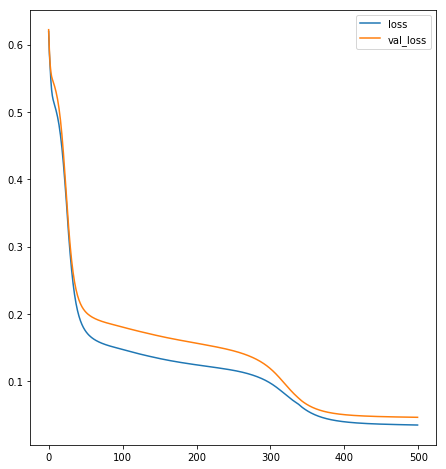

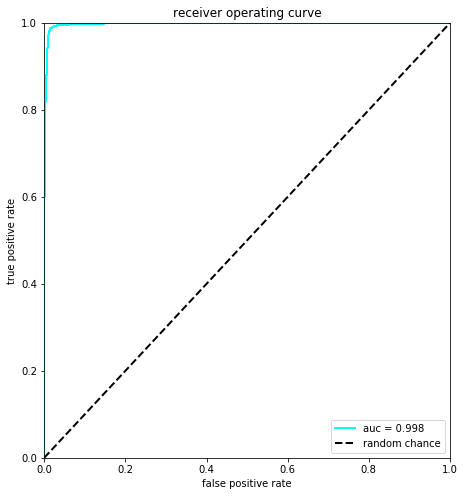

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

with torch.no_grad():
    # plot loss vs epoch
    plt.figure(figsize=(16,8))
    ax = plt.subplot(1, 2, 1)
    ax.plot(losses, label='loss')
    ax.plot(val_losses, label='val_loss')
    ax.legend(loc="upper right")
    plt.show()


    # Plot ROC
    X_test_in = torch.from_numpy(X_test).float()
    Y_predict = model(X_test_in)
    from sklearn.metrics import roc_curve, auc
    fpr, tpr, thresholds = roc_curve(Y_test, Y_predict)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(16,8))
    ax2 = plt.subplot(1, 2, 2)
    ax2.plot(fpr, tpr, lw=2, color='cyan', label='auc = %.3f' % (roc_auc))
    ax2.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
    ax2.set_xlim([0, 1.0])
    ax2.set_ylim([0, 1.0])
    ax2.set_xlabel('false positive rate')
    ax2.set_ylabel('true positive rate')
    ax2.set_title('receiver operating curve')
    ax2.legend(loc="lower right")
    plt.show()

In [11]:
# Hint: We want to make a three 2D numpy arrays: 
# x values at each (x, y) grid point
# y values at each (x, y) grid point
# z values (model prediction) at each (x, y) grid point

myXI, myYI = np.meshgrid(np.linspace(-2, 2, 200), np.linspace(-2, 2, 200))
# print shape
print(myXI.shape)

myZI = np.zeros(myXI.shape)

for i in range(0, len(myXI)):
    for j in range(0, len(myYI)):
        myXI[i,j] # x value of xi, yj point
        myYI[i,j] # y value of xi, yj point
        data_point = torch.tensor([myXI[i,j], myYI[i,j]])
        myZI[i,j] = model(data_point)

(200, 200)


In [12]:
print(myZI)
myZI = model(torch.from_numpy(np.c_[myXI.ravel(), myYI.ravel()]).float())
myZI = myZI.reshape(myXI.shape)

[[2.63522696e-02 2.62143947e-02 2.60783266e-02 ... 4.65386052e-04
  4.65934660e-04 4.66495723e-04]
 [2.65331957e-02 2.63921972e-02 2.62530334e-02 ... 4.68519196e-04
  4.69045568e-04 4.69584862e-04]
 [2.67202053e-02 2.65759937e-02 2.64336411e-02 ... 4.71701467e-04
  4.72205575e-04 4.72723041e-04]
 ...
 [6.32012367e-01 6.33274436e-01 6.34508491e-01 ... 1.44819161e-02
  1.41338380e-02 1.37963248e-02]
 [6.33853912e-01 6.35086954e-01 6.36292577e-01 ... 1.47519661e-02
  1.43991765e-02 1.40570039e-02]
 [6.35649621e-01 6.36853933e-01 6.38031542e-01 ... 1.50235444e-02
  1.46660944e-02 1.43193062e-02]]


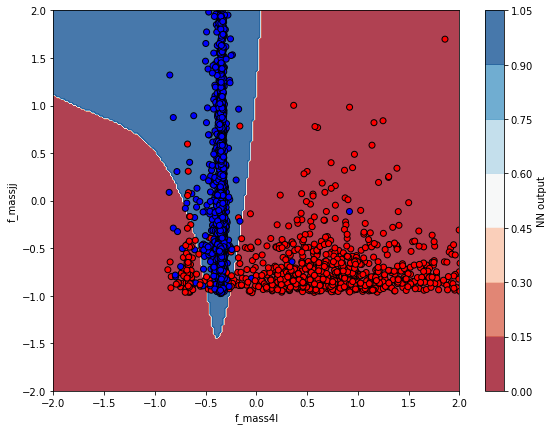

In [13]:
from matplotlib.colors import ListedColormap
plt.figure(figsize=(20,7))

# plot contour map of NN output
# overlaid with test data points
ax = plt.subplot(1, 2, 1)
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

cont_plot = ax.contourf(myXI, myYI, myZI>0.5, cmap=cm, alpha=.8)
ax.scatter(X_test[:, 0], X_test[:, 1], c=Y_test, cmap=cm_bright, edgecolors='k')
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
ax.set_xlabel(VARS[0])
ax.set_ylabel(VARS[1])
plt.colorbar(cont_plot,ax=ax, boundaries=[0,1],label='NN output')

# plot decision boundary
# overlaid with test data points

In [14]:
# -*- coding: utf-8 -*-
import random
import torch


class DynamicNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        In the constructor we construct three nn.Linear instances that we will use
        in the forward pass.
        """
        super(DynamicNet, self).__init__()
        self.input_linear = torch.nn.Linear(D_in, H)
        self.middle_linear = torch.nn.Linear(H, H)
        self.output_linear = torch.nn.Linear(H, D_out)
        self.sig = torch.nn.Sigmoid()

    def forward(self, x):
        """
        For the forward pass of the model, we randomly choose either 0, 1, 2, or 3
        and reuse the middle_linear Module that many times to compute hidden layer
        representations.

        Since each forward pass builds a dynamic computation graph, we can use normal
        Python control-flow operators like loops or conditional statements when
        defining the forward pass of the model.

        Here we also see that it is perfectly safe to reuse the same Module many
        times when defining a computational graph. This is a big improvement from Lua
        Torch, where each Module could be used only once.
        """
        h_relu = self.input_linear(x).clamp(min=0)
        for _ in range(random.randint(0, 3)):
            h_relu = self.middle_linear(h_relu).clamp(min=0)
        y_pred = self.sig(self.output_linear(h_relu))
        return y_pred


# Construct our model by instantiating the class defined above
rand_model = DynamicNet(2, 20, 1)

# Construct our loss function and an Optimizer. Training this strange model with
# vanilla stochastic gradient descent is tough, so we use momentum
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
rand_losses = []
for t in xrange(3000):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = rand_model(unbatched_x)

    # Compute and print loss
    y = unbatched_y.view_as(y_pred)
    loss = criterion(y_pred, y)
    rand_losses.append(loss.item())
    print(t, loss.item())

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

(0, 0.766834020614624)
(1, 0.766834020614624)
(2, 0.7326927185058594)
(3, 0.7376439571380615)
(4, 0.7117282748222351)
(5, 0.7376439571380615)
(6, 0.766834020614624)
(7, 0.7117282748222351)
(8, 0.7376439571380615)
(9, 0.7117282748222351)
(10, 0.7117282748222351)
(11, 0.7376439571380615)
(12, 0.7117282748222351)
(13, 0.7326927185058594)
(14, 0.766834020614624)
(15, 0.7117282748222351)
(16, 0.7326927185058594)
(17, 0.7326927185058594)
(18, 0.7376439571380615)
(19, 0.766834020614624)
(20, 0.766834020614624)
(21, 0.766834020614624)
(22, 0.7326927185058594)
(23, 0.7326927185058594)
(24, 0.7376439571380615)
(25, 0.7326927185058594)
(26, 0.7326927185058594)
(27, 0.7326927185058594)
(28, 0.7326927185058594)
(29, 0.7326927185058594)
(30, 0.7117282748222351)
(31, 0.7376439571380615)
(32, 0.766834020614624)
(33, 0.7326927185058594)
(34, 0.7376439571380615)
(35, 0.7376439571380615)
(36, 0.7326927185058594)
(37, 0.766834020614624)
(38, 0.7376439571380615)
(39, 0.7117282748222351)
(40, 0.737643957138

(334, 0.7376439571380615)
(335, 0.766834020614624)
(336, 0.7376439571380615)
(337, 0.7117282748222351)
(338, 0.766834020614624)
(339, 0.7376439571380615)
(340, 0.766834020614624)
(341, 0.7326927185058594)
(342, 0.7376439571380615)
(343, 0.766834020614624)
(344, 0.7376439571380615)
(345, 0.7326927185058594)
(346, 0.766834020614624)
(347, 0.7117282748222351)
(348, 0.7326927185058594)
(349, 0.7117282748222351)
(350, 0.7376439571380615)
(351, 0.766834020614624)
(352, 0.766834020614624)
(353, 0.766834020614624)
(354, 0.7117282748222351)
(355, 0.7117282748222351)
(356, 0.7376439571380615)
(357, 0.7326927185058594)
(358, 0.7376439571380615)
(359, 0.766834020614624)
(360, 0.7117282748222351)
(361, 0.7117282748222351)
(362, 0.7117282748222351)
(363, 0.766834020614624)
(364, 0.7326927185058594)
(365, 0.766834020614624)
(366, 0.766834020614624)
(367, 0.7326927185058594)
(368, 0.7117282748222351)
(369, 0.7326927185058594)
(370, 0.7117282748222351)
(371, 0.7376439571380615)
(372, 0.766834020614624)

(664, 0.766834020614624)
(665, 0.7376439571380615)
(666, 0.7326927185058594)
(667, 0.7117282748222351)
(668, 0.7117282748222351)
(669, 0.7376439571380615)
(670, 0.766834020614624)
(671, 0.7376439571380615)
(672, 0.7376439571380615)
(673, 0.766834020614624)
(674, 0.7376439571380615)
(675, 0.766834020614624)
(676, 0.7326927185058594)
(677, 0.7117282748222351)
(678, 0.766834020614624)
(679, 0.7326927185058594)
(680, 0.7117282748222351)
(681, 0.7117282748222351)
(682, 0.7376439571380615)
(683, 0.7326927185058594)
(684, 0.7117282748222351)
(685, 0.7117282748222351)
(686, 0.7117282748222351)
(687, 0.766834020614624)
(688, 0.7376439571380615)
(689, 0.7376439571380615)
(690, 0.766834020614624)
(691, 0.766834020614624)
(692, 0.7117282748222351)
(693, 0.7117282748222351)
(694, 0.7376439571380615)
(695, 0.7326927185058594)
(696, 0.766834020614624)
(697, 0.766834020614624)
(698, 0.766834020614624)
(699, 0.766834020614624)
(700, 0.7117282748222351)
(701, 0.766834020614624)
(702, 0.7117282748222351)

(994, 0.7117282748222351)
(995, 0.766834020614624)
(996, 0.766834020614624)
(997, 0.766834020614624)
(998, 0.7326927185058594)
(999, 0.7376439571380615)
(1000, 0.7117282748222351)
(1001, 0.7376439571380615)
(1002, 0.7117282748222351)
(1003, 0.7376439571380615)
(1004, 0.7376439571380615)
(1005, 0.766834020614624)
(1006, 0.766834020614624)
(1007, 0.7117282748222351)
(1008, 0.7117282748222351)
(1009, 0.766834020614624)
(1010, 0.766834020614624)
(1011, 0.766834020614624)
(1012, 0.766834020614624)
(1013, 0.766834020614624)
(1014, 0.766834020614624)
(1015, 0.7376439571380615)
(1016, 0.766834020614624)
(1017, 0.7117282748222351)
(1018, 0.7376439571380615)
(1019, 0.7326927185058594)
(1020, 0.766834020614624)
(1021, 0.766834020614624)
(1022, 0.7376439571380615)
(1023, 0.7376439571380615)
(1024, 0.7117282748222351)
(1025, 0.7376439571380615)
(1026, 0.7376439571380615)
(1027, 0.7376439571380615)
(1028, 0.7376439571380615)
(1029, 0.7376439571380615)
(1030, 0.7326927185058594)
(1031, 0.732692718505

(1305, 0.766834020614624)
(1306, 0.7326927185058594)
(1307, 0.766834020614624)
(1308, 0.766834020614624)
(1309, 0.766834020614624)
(1310, 0.7117282748222351)
(1311, 0.766834020614624)
(1312, 0.7117282748222351)
(1313, 0.7326927185058594)
(1314, 0.7326927185058594)
(1315, 0.7376439571380615)
(1316, 0.7117282748222351)
(1317, 0.7326927185058594)
(1318, 0.766834020614624)
(1319, 0.7376439571380615)
(1320, 0.7376439571380615)
(1321, 0.766834020614624)
(1322, 0.7376439571380615)
(1323, 0.7117282748222351)
(1324, 0.766834020614624)
(1325, 0.7376439571380615)
(1326, 0.7117282748222351)
(1327, 0.7117282748222351)
(1328, 0.766834020614624)
(1329, 0.7117282748222351)
(1330, 0.7117282748222351)
(1331, 0.7326927185058594)
(1332, 0.766834020614624)
(1333, 0.7117282748222351)
(1334, 0.7376439571380615)
(1335, 0.7326927185058594)
(1336, 0.7376439571380615)
(1337, 0.7376439571380615)
(1338, 0.766834020614624)
(1339, 0.7117282748222351)
(1340, 0.7376439571380615)
(1341, 0.7117282748222351)
(1342, 0.737

(1616, 0.7376439571380615)
(1617, 0.7326927185058594)
(1618, 0.7117282748222351)
(1619, 0.7326927185058594)
(1620, 0.7326927185058594)
(1621, 0.7376439571380615)
(1622, 0.7376439571380615)
(1623, 0.7326927185058594)
(1624, 0.7117282748222351)
(1625, 0.766834020614624)
(1626, 0.766834020614624)
(1627, 0.7326927185058594)
(1628, 0.7117282748222351)
(1629, 0.7326927185058594)
(1630, 0.766834020614624)
(1631, 0.7326927185058594)
(1632, 0.7117282748222351)
(1633, 0.766834020614624)
(1634, 0.7376439571380615)
(1635, 0.766834020614624)
(1636, 0.766834020614624)
(1637, 0.7376439571380615)
(1638, 0.7326927185058594)
(1639, 0.7326927185058594)
(1640, 0.7326927185058594)
(1641, 0.7117282748222351)
(1642, 0.7326927185058594)
(1643, 0.7326927185058594)
(1644, 0.7117282748222351)
(1645, 0.7326927185058594)
(1646, 0.766834020614624)
(1647, 0.7326927185058594)
(1648, 0.7117282748222351)
(1649, 0.766834020614624)
(1650, 0.7376439571380615)
(1651, 0.766834020614624)
(1652, 0.7326927185058594)
(1653, 0.7

(1930, 0.766834020614624)
(1931, 0.7326927185058594)
(1932, 0.7117282748222351)
(1933, 0.7326927185058594)
(1934, 0.7326927185058594)
(1935, 0.7117282748222351)
(1936, 0.766834020614624)
(1937, 0.766834020614624)
(1938, 0.766834020614624)
(1939, 0.766834020614624)
(1940, 0.7117282748222351)
(1941, 0.7117282748222351)
(1942, 0.7376439571380615)
(1943, 0.766834020614624)
(1944, 0.7376439571380615)
(1945, 0.7326927185058594)
(1946, 0.7326927185058594)
(1947, 0.766834020614624)
(1948, 0.7117282748222351)
(1949, 0.766834020614624)
(1950, 0.766834020614624)
(1951, 0.7117282748222351)
(1952, 0.7117282748222351)
(1953, 0.7326927185058594)
(1954, 0.7326927185058594)
(1955, 0.7326927185058594)
(1956, 0.7117282748222351)
(1957, 0.7117282748222351)
(1958, 0.7117282748222351)
(1959, 0.766834020614624)
(1960, 0.7376439571380615)
(1961, 0.766834020614624)
(1962, 0.7326927185058594)
(1963, 0.7326927185058594)
(1964, 0.7117282748222351)
(1965, 0.766834020614624)
(1966, 0.7117282748222351)
(1967, 0.7117

(2247, 0.766834020614624)
(2248, 0.7117282748222351)
(2249, 0.7117282748222351)
(2250, 0.7376439571380615)
(2251, 0.7376439571380615)
(2252, 0.7376439571380615)
(2253, 0.766834020614624)
(2254, 0.7326927185058594)
(2255, 0.7376439571380615)
(2256, 0.7326927185058594)
(2257, 0.7117282748222351)
(2258, 0.766834020614624)
(2259, 0.7117282748222351)
(2260, 0.7376439571380615)
(2261, 0.766834020614624)
(2262, 0.7326927185058594)
(2263, 0.7117282748222351)
(2264, 0.7117282748222351)
(2265, 0.7376439571380615)
(2266, 0.7326927185058594)
(2267, 0.7117282748222351)
(2268, 0.766834020614624)
(2269, 0.7117282748222351)
(2270, 0.7376439571380615)
(2271, 0.7117282748222351)
(2272, 0.7326927185058594)
(2273, 0.7376439571380615)
(2274, 0.766834020614624)
(2275, 0.766834020614624)
(2276, 0.7376439571380615)
(2277, 0.7326927185058594)
(2278, 0.766834020614624)
(2279, 0.7376439571380615)
(2280, 0.7376439571380615)
(2281, 0.7376439571380615)
(2282, 0.7117282748222351)
(2283, 0.766834020614624)
(2284, 0.7

(2554, 0.7117282748222351)
(2555, 0.766834020614624)
(2556, 0.766834020614624)
(2557, 0.7376439571380615)
(2558, 0.7117282748222351)
(2559, 0.7326927185058594)
(2560, 0.7376439571380615)
(2561, 0.766834020614624)
(2562, 0.7117282748222351)
(2563, 0.766834020614624)
(2564, 0.7117282748222351)
(2565, 0.7117282748222351)
(2566, 0.7376439571380615)
(2567, 0.7117282748222351)
(2568, 0.7376439571380615)
(2569, 0.766834020614624)
(2570, 0.7376439571380615)
(2571, 0.7326927185058594)
(2572, 0.7376439571380615)
(2573, 0.766834020614624)
(2574, 0.7326927185058594)
(2575, 0.7376439571380615)
(2576, 0.766834020614624)
(2577, 0.7376439571380615)
(2578, 0.7326927185058594)
(2579, 0.7117282748222351)
(2580, 0.766834020614624)
(2581, 0.766834020614624)
(2582, 0.7326927185058594)
(2583, 0.7117282748222351)
(2584, 0.7326927185058594)
(2585, 0.7117282748222351)
(2586, 0.7326927185058594)
(2587, 0.7326927185058594)
(2588, 0.7326927185058594)
(2589, 0.7376439571380615)
(2590, 0.7376439571380615)
(2591, 0.7

(2870, 0.7326927185058594)
(2871, 0.7326927185058594)
(2872, 0.7326927185058594)
(2873, 0.7376439571380615)
(2874, 0.766834020614624)
(2875, 0.7117282748222351)
(2876, 0.7326927185058594)
(2877, 0.766834020614624)
(2878, 0.7117282748222351)
(2879, 0.7326927185058594)
(2880, 0.7326927185058594)
(2881, 0.7117282748222351)
(2882, 0.7326927185058594)
(2883, 0.7117282748222351)
(2884, 0.7326927185058594)
(2885, 0.7117282748222351)
(2886, 0.766834020614624)
(2887, 0.7326927185058594)
(2888, 0.7326927185058594)
(2889, 0.766834020614624)
(2890, 0.766834020614624)
(2891, 0.7376439571380615)
(2892, 0.7326927185058594)
(2893, 0.7376439571380615)
(2894, 0.7117282748222351)
(2895, 0.7376439571380615)
(2896, 0.7326927185058594)
(2897, 0.7117282748222351)
(2898, 0.7326927185058594)
(2899, 0.766834020614624)
(2900, 0.7117282748222351)
(2901, 0.7376439571380615)
(2902, 0.7117282748222351)
(2903, 0.7376439571380615)
(2904, 0.766834020614624)
(2905, 0.7326927185058594)
(2906, 0.7376439571380615)
(2907, 0

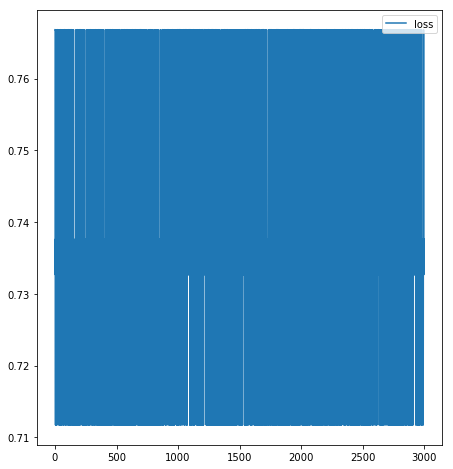

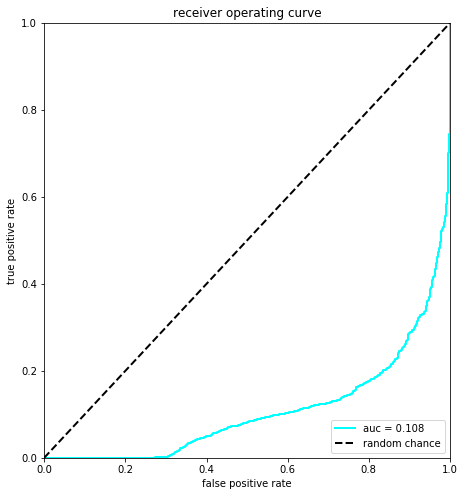

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

with torch.no_grad():
    # plot loss vs epoch
    plt.figure(figsize=(16,8))
    ax = plt.subplot(1, 2, 1)
    ax.plot(rand_losses, label='loss')
#     ax.plot(val_losses, label='val_loss')
    ax.legend(loc="upper right")
    plt.show()


    # Plot ROC
    X_test_in = torch.from_numpy(X_test).float()
    Y_predict = rand_model(X_test_in)
    from sklearn.metrics import roc_curve, auc
    fpr, tpr, thresholds = roc_curve(Y_test, Y_predict)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(16,8))
    ax2 = plt.subplot(1, 2, 2)
    ax2.plot(fpr, tpr, lw=2, color='cyan', label='auc = %.3f' % (roc_auc))
    ax2.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
    ax2.set_xlim([0, 1.0])
    ax2.set_ylim([0, 1.0])
    ax2.set_xlabel('false positive rate')
    ax2.set_ylabel('true positive rate')
    ax2.set_title('receiver operating curve')
    ax2.legend(loc="lower right")
    plt.show()

In [16]:
# Hint: We want to make a three 2D numpy arrays: 
# x values at each (x, y) grid point
# y values at each (x, y) grid point
# z values (model prediction) at each (x, y) grid point

myXI, myYI = np.meshgrid(np.linspace(-2, 2, 200), np.linspace(-2, 2, 200))
# print shape
print(myXI.shape)

myZI = np.zeros(myXI.shape)

for i in range(0, len(myXI)):
    for j in range(0, len(myYI)):
        myXI[i,j] # x value of xi, yj point
        myYI[i,j] # y value of xi, yj point
        data_point = torch.tensor([myXI[i,j], myYI[i,j]])
        myZI[i,j] = rand_model(data_point)

(200, 200)


In [17]:
print(myZI)
myZI = rand_model(torch.from_numpy(np.c_[myXI.ravel(), myYI.ravel()]).float())
myZI = myZI.reshape(myXI.shape)

[[0.4546127  0.65232843 0.45496601 ... 0.54756081 0.54791653 0.46306649]
 [0.46096703 0.45907483 0.65071493 ... 0.46478119 0.54739207 0.46459317]
 [0.65008628 0.64975697 0.46088341 ... 0.46299356 0.46449721 0.46312934]
 ...
 [0.47689176 0.46154159 0.46156713 ... 0.45913473 0.45901939 0.56578177]
 [0.47605598 0.44482747 0.45999122 ... 0.46343687 0.46339622 0.56578434]
 [0.4615123  0.44472155 0.44470701 ... 0.46337461 0.46333399 0.47001758]]


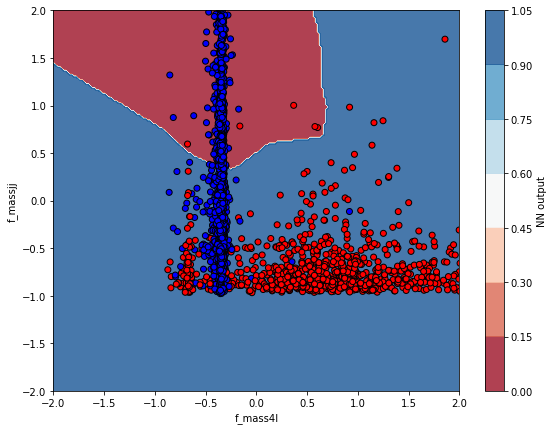

In [18]:
from matplotlib.colors import ListedColormap
plt.figure(figsize=(20,7))

# plot contour map of NN output
# overlaid with test data points
ax = plt.subplot(1, 2, 1)
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

cont_plot = ax.contourf(myXI, myYI, myZI>0.5, cmap=cm, alpha=.8)
ax.scatter(X_test[:, 0], X_test[:, 1], c=Y_test, cmap=cm_bright, edgecolors='k')
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
ax.set_xlabel(VARS[0])
ax.set_ylabel(VARS[1])
plt.colorbar(cont_plot,ax=ax, boundaries=[0,1],label='NN output')

# plot decision boundary
# overlaid with test data points